In [1]:
import os
import sys

import numpy as np
import pylab as pl

%matplotlib inline

In [2]:
pl.style.use('fabiostyle')

# import pandas

sys.path.append('../../../../code/')  # to be replaced!
import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'lambo'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
# load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
folder = './autorestore/preprocessing'
for var in ('time_ax', 'traces', 'events', 'areas', 'cycles', 'licks', 'odor_CSm_ons', 'odor_rw_ons', 'rewards',
            'is_rewardt', 'is_CSmt', 'CYCLE_DURATION', 'CYCLE_START', 'CS_DURATION', 'DELAY', 'AFTER_DELAY_DURATION'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))

In [6]:
licks_bs = 1.*ut.compute_licks_during(licks, cycles,
                                      start=-CYCLE_START-DELAY,
                                      end=-CYCLE_START)  # w.r.t. cycle start
licks_cs = 1.*ut.compute_licks_during(licks, cycles,
                                      start=-CYCLE_START,
                                      end=-CYCLE_START+CS_DURATION)
licks_tc = 1.*ut.compute_licks_during(licks, cycles,
                                      start=-CYCLE_START+CS_DURATION,
                                         end=-CYCLE_START+CS_DURATION+DELAY)
licks_cs_tc = 1.*ut.compute_licks_during(licks, cycles,
                                         start=-CYCLE_START,
                                         end=-CYCLE_START+CS_DURATION+DELAY)
licks_tc_us = 1.*ut.compute_licks_during(licks, cycles,
                                         start=-CYCLE_START+CS_DURATION,
                                         end=-CYCLE_START+CS_DURATION+DELAY+AFTER_DELAY_DURATION)
licks_cs_tc_us = 1.*ut.compute_licks_during(licks, cycles,
                                      start=-CYCLE_START,
                                      end=-CYCLE_START+CS_DURATION+DELAY+AFTER_DELAY_DURATION)
lick_ratios = np.r_[[(l/(l+b) if (l+b)>0 else 0) for l, b in zip(licks_cs_tc, licks_bs)]]
lick_di = np.nan_to_num(1.*(np.mean(licks_cs_tc[is_rewardt]-licks_bs[is_rewardt]) -
                            np.mean(licks_cs_tc[is_CSmt]-licks_bs[is_CSmt]))/np.sqrt(0.5*(np.std(licks_cs_tc)**2+np.std(licks_bs)**2)))

good_lick_trials = (licks_bs+licks_tc_us) >= 5

In [7]:
def plot_licks(tone_onsets, licks, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1)
    for i, tone_ons in enumerate(tone_onsets):
        lick_filt = ((licks-tone_ons)>CYCLE_START) * ((licks-tone_ons)<CYCLE_DURATION)
        ax.vlines((licks-tone_ons)[lick_filt], i, i+1, lw=0.5)
    return ax

In [8]:
reward_times = []
for s, e in cycles[is_rewardt]:
# s, e = cycles[np.where(is_rewardt)[0][i]]
    try:
        r = rewards[(rewards>=s)*(rewards<e)][0]
        later_licks = licks-r
        reward_times.append(later_licks[(later_licks>=0)][0])
    except:
        reward_times.append(np.nan)

In [9]:
reward_times = np.r_[reward_times]

In [10]:
is_rewarded = reward_times<2

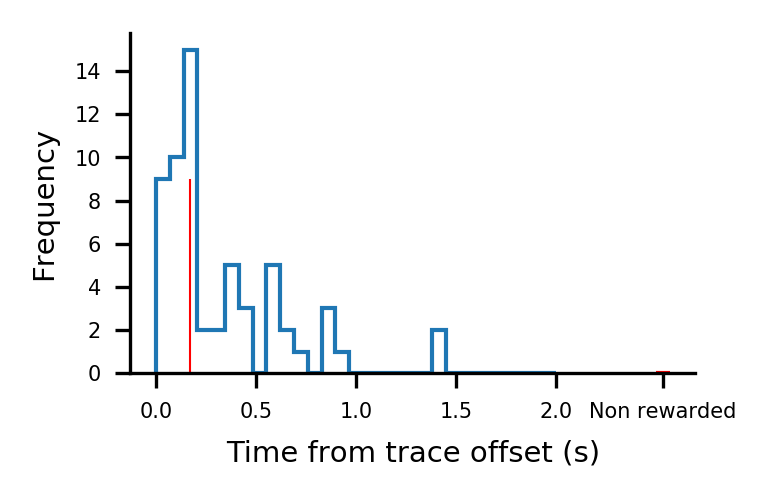

In [11]:
fig, ax = pl.subplots(1, 1)
ax.hist(reward_times[reward_times<2], bins=np.linspace(0, 2, 30), histtype='step');
ax.hist((reward_times>=2)*2.5, bins=[2.5, 2.5+2./30], histtype='step', color='r');
ax.set_xticks(np.r_[np.arange(0, 2.1, 0.5), 2.5+1./30])
ax.set_xticklabels([i for i in np.arange(0, 2.1, 0.5)] + ['Non rewarded'])

ax.vlines(np.median(reward_times), 0, 9, 'r')

ax.set_xlabel('Time from trace offset (s)')
ax.set_ylabel('Frequency')

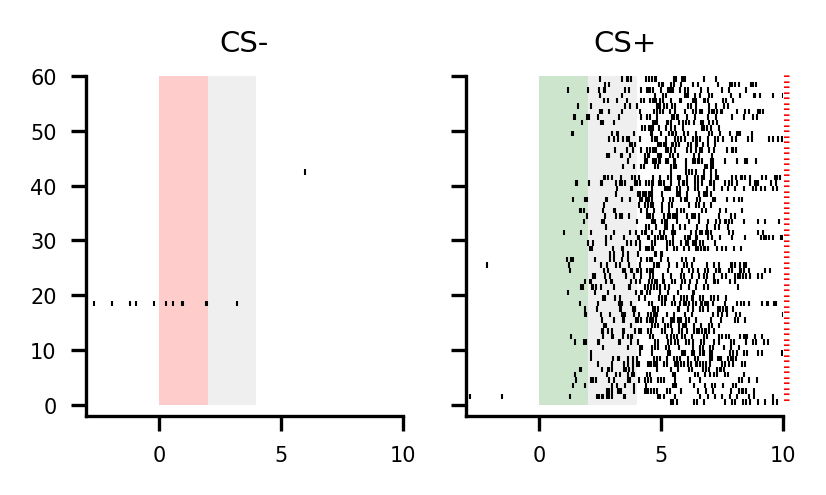

In [12]:
fig, axs = pl.subplots(1, 2, figsize=(3, 1.5), sharey=True)
plot_licks(odor_CSm_ons, licks, ax=axs[0])
axs[0].set_title('CS-')
plot_licks(odor_rw_ons, licks, ax=axs[1])
axs[1].set_title('CS+')
for c, ax in zip(['r', 'g'], axs):
    ax.set_xlim(CYCLE_START, CYCLE_START+CYCLE_DURATION)
    
    ax.set_ylim(-2, len(odor_CSm_ons))
    ax.set_xlim(-3, 10)
    
    pt.plot_period_bar(ax, 0, color=c, start_end=(0, CS_DURATION), alpha=0.2, zorder=0, delta_y=len(odor_CSm_ons))
    pt.plot_period_bar(ax, 0, color='0.7', start_end=(CS_DURATION, CS_DURATION+DELAY),
                       delta_y=len(odor_CSm_ons), alpha=0.2, zorder=0)
    
    pt.nicer_plot(ax)

[axs[1].text(10, i, "-", color="r") for i, v in enumerate(np.r_[is_rewarded]) if v];
[axs[1].text(10, i, "-", color="b") for i, v in enumerate(np.r_[is_rewarded]) if not v];
# fig.savefig("../img/lambo.pdf")

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [14]:
lr = LinearRegression()
labels = (np.r_[is_rewardt] * 0) + (np.r_[is_CSmt] * 1)

In [15]:
%%time
lick_scores = []
n_train = 10
n_test = 4
for i in range(len(labels)-n_train-n_test):
    which_train = range(i, i+n_train)
    which_test = range(i+1+n_train, i+1+n_train+n_test)
    lr.fit(lick_ratios[which_train].reshape(-1, 1), labels[which_train])
    lick_scores.append(lr.score(lick_ratios[which_test].reshape(-1, 1), labels[which_test]))
    
lick_scores = np.r_[lick_scores]

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 61.1 ms


In [16]:
%%time
lick_scores_cv = []
n_train = 10
n_test = 4
for i in range(len(labels)-n_train-n_test):
    which = range(i, i+n_train+n_test)
    lick_scores_cv.append(cross_val_score(lr, lick_ratios[which].reshape(-1, 1), labels[which], cv=5))
    
lick_scores_cv = np.r_[lick_scores_cv]

CPU times: user 980 ms, sys: 0 ns, total: 980 ms
Wall time: 977 ms


In [17]:
n_licks = np.r_[[((licks>=(s-CYCLE_START)) * (licks<(s-CYCLE_START+CS_DURATION+DELAY))).sum() for s, e in cycles]]

In [18]:
# %%time
lick_dis = []
n_train = 10
n_test = 4
for i in range(len(n_licks)-n_train-n_test):
    which_test = range(i+1+n_train, i+1+n_train+n_test)
    l_CSmt = n_licks[which_test][np.r_[is_CSmt][which_test]].sum()
    l_rewardt = n_licks[which_test][np.r_[is_rewardt][which_test]].sum()
    # compute lick DIs here:
    try:
        lick_dis.append(1.*l_rewardt/(l_rewardt+l_CSmt))
    except ZeroDivisionError:
        lick_dis.append(0)
    
lick_dis = np.r_[lick_dis]

In [19]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
